<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#connection-matrix" data-toc-modified-id="connection-matrix-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>connection matrix</a></span></li><li><span><a href="#edge-list-and-node/edge-attribute-list" data-toc-modified-id="edge-list-and-node/edge-attribute-list-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>edge list and node/edge attribute list</a></span></li></ul></li><li><span><a href="#Network-Visualization" data-toc-modified-id="Network-Visualization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Network Visualization</a></span><ul class="toc-item"><li><span><a href="#network-parameters" data-toc-modified-id="network-parameters-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>network parameters</a></span></li><li><span><a href="#network-vis-examples" data-toc-modified-id="network-vis-examples-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>network vis examples</a></span><ul class="toc-item"><li><span><a href="#network-of-all" data-toc-modified-id="network-of-all-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>network of all</a></span></li><li><span><a href="#network-of-key-people" data-toc-modified-id="network-of-key-people-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>network of key people</a></span></li><li><span><a href="#network-of-sender-(directed-graph)" data-toc-modified-id="network-of-sender-(directed-graph)-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>network of sender (directed graph)</a></span></li><li><span><a href="#network-of-commissioners" data-toc-modified-id="network-of-commissioners-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>network of commissioners</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import re
import pickle
from function_library import *
from function_library2 import *

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


# Preprocessing

## connection matrix

Extract inforation and build connection matrix from the emails.

All the network plots are based on such a matrix. Network analysis needs similar type of data (in my understanding). 

The rows are the senders and the columns are the receivers. There are 4917 people appear in the emails, so the connection matrix is 4917 by 4917. The value of mat[i,j] means the number of emails sent from ith person to jth person.

This connection matrix is equivalent to the weighted adjacency matrix in graph theory, but the rows and columns are sorted.

In [2]:
l_to   = fromPickle("to_list")
l_from = fromPickle("from_list")
l_cc   = fromPickle("cc_list")

l_to = standardize_triplet(l_to)
l_from = standardize_triplet(l_from)
l_cc = standardize_triplet(l_cc)

unique_people = set()
for i in range(len(l_from)):
    unique_people.add(l_from[i])

for i in range(len(l_cc)):
    for lst in l_cc[i]:
        unique_people.add(lst)

for i in range(len(l_to)):
    for lst in l_to[i]:
        unique_people.add(lst)
unique_people = list(unique_people)
unique_people.sort()
name2id, id2name = nameToIndexDict(unique_people)

# s2r is sender to recipient
s2r = createConnectionMatrix(unique_people, name2id, l_from=l_from, l_to=l_to, l_cc=l_cc)
s2r.shape

(4917, 4917)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/joey/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0 to DejaVu Sans ('/Users/joey/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


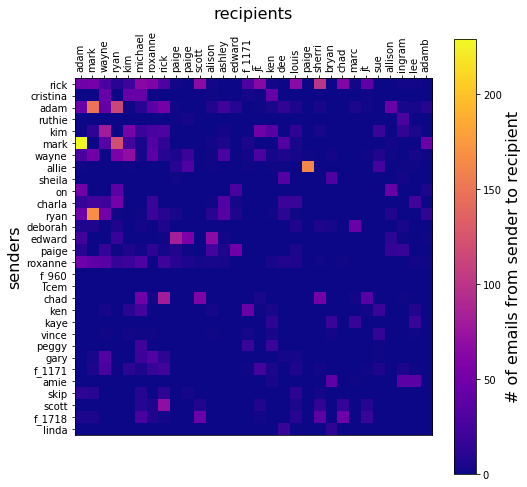

In [3]:
plot_connection_matrix(s2r, unique_people, sort=True, top=30, figsize=(8,8))

## edge list and node/edge attribute list

Besides the connection/adjacency matrix, another frequent used representation is the edge list. The edge list is consisted of edges. Each edge has two elements. The first is the starting point and the second is the ending point.

In [4]:
edge_list = []

# edge attributes includes: #email from A to B, #email from B to A, #email between A and B
edge_attr_list = []
for i in range(s2r.shape[0]):
    for j in range(i+1, s2r.shape[1]):
        if s2r[i,j] + s2r[j,i] > 0:
            edge_list.append((unique_people[i], unique_people[j]))
            edge_attr_list.append([(i,j),s2r[i,j], s2r[j,i], s2r[i,j] + s2r[j,i]])


In [5]:
# showing an example of edge list
edge_list[-1]

(('will', 'butler', 'w.f.butler@embarqmail.com'),
 ('william', 'butler', 'will@realestateinsync.com'))

In [6]:
node_list = unique_people.copy()

# node attributes includes: #email sent, #email received, #email total, #people send, #people received, #people connected
node_attr_list = np.zeros((7,s2r.shape[0]))

number_of_e_send = np.sum(s2r, axis = 1)
number_of_e_receive = np.sum(s2r,axis = 0)
number_of_email = number_of_e_send + number_of_e_receive

adjacency_mat = s2r>0
number_of_p_send = np.sum(adjacency_mat, axis = 1)
number_of_p_receive = np.sum(adjacency_mat,axis = 0)
number_of_people_connected = number_of_p_send + number_of_p_receive

node_attr_list[0,:] = np.arange(len(node_list),dtype=int)
node_attr_list[1,:] = number_of_e_send
node_attr_list[2,:] = number_of_e_receive
node_attr_list[3,:] = number_of_email
node_attr_list[4,:] = number_of_p_send # outdegree
node_attr_list[5,:] = number_of_p_receive # indegree
node_attr_list[6,:] = number_of_people_connected


Besides the edge list, we can also take advantage of other information and put them on the edge or node. So we can build edge attribute list and node attribute list for further analysis.

In [7]:
df_edge = pd.DataFrame(data=edge_attr_list,columns=['edge', '#email from A to B', '#email from B to A', '#email between A and B'])
df_edge.head()


,edge,#email from A to B,#email from B to A,#email between A and B
0,"(0, 5)",1,0,1
1,"(0, 17)",0,1,1
2,"(0, 25)",1,0,1
3,"(0, 30)",1,0,1
4,"(0, 36)",1,0,1


In [8]:
df_node = pd.DataFrame(data=node_attr_list.T.tolist(),columns=['node','#email sent', '#email received', '#email total', 'out degree', 'in degree', '#people connected'])
df_node.head()


,node,#email sent,#email received,#email total,out degree,in degree,#people connected
0,0.0,903.0,1390.0,2293.0,506.0,283.0,789.0
1,1.0,0.0,1.0,1.0,0.0,1.0,1.0
2,2.0,28.0,1.0,29.0,28.0,1.0,29.0
3,3.0,2.0,6.0,8.0,2.0,4.0,6.0
4,4.0,0.0,1.0,1.0,0.0,1.0,1.0


# Network Visualization

Using python package **networkx**

The position of the nodes is calculated by the algorithm. **Edges are considered as springs**. We can change the spring coefficient but not the edge distance directly. The algorithm will automatically find a solution to minimize the system energy.

**Therefore, there are two potential problems with it**:
- Position calculation is stochastic. Different runs may get different figures
- The figure may not be able to reflect its really property.

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=30.0 to DejaVu Sans ('/Users/joey/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


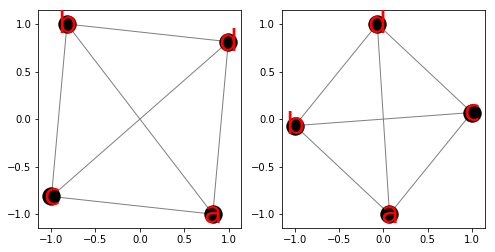

In [9]:
# an example illustrating the above problems
G = nx.Graph()

G.add_edge('a','b',weight = 1)
G.add_edge('a','c',weight = 1)
G.add_edge('a','d',weight = 1)
G.add_edge('b','c',weight = 1)
G.add_edge('b','d',weight = 1)
G.add_edge('c','d',weight = 1)
# this is a tetrahedron

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
pos = nx.spring_layout(G) # recalculating position
nx.draw_networkx_nodes(G, pos,node_color = 'black')
nx.draw_networkx_edges(G, pos, width=1, edge_color = 'grey')
nx.draw_networkx_labels(G, pos, labels={'a':'a','b':'b','c':'c','d':'d'}, font_size=30, font_color='red')

plt.subplot(1,2,2)
pos = nx.spring_layout(G) # recalculating position
nx.draw_networkx_nodes(G, pos,node_color = 'black')
nx.draw_networkx_edges(G, pos, width=1, edge_color = 'grey')
nx.draw_networkx_labels(G, pos, labels={'a':'a','b':'b','c':'c','d':'d'}, font_size=30, font_color='red')
plt.show()

## network parameters  
Nodes choices:
- all nodes
- nodes who has more than x emails related
- nodes who has more than x emails with at least one another node
- nodes who is active during a specific time

Node size option: 
- number of emails sent/received/related
- number of people connected. (similar to the centrality, indegree and outdegree)

Edge width option: 
- number of emails between two people
- number of emails sent/received (directed graph)

arrow direction option: (directed graph)
- if A sent B more than B sent A, then the arrow is from A to B 

## network vis examples
### network of all

In [ ]:
plot_network(s2r,id2name)

emails: all  
nodes: all  
node size: number of emails sent and received  
edges: all  
edge width: number of emails between two nodes  
node label: none

### network of key people


In [ ]:
plot_network(s2r,id2name, edge_threshold = 30, draw_labels = True, label_threshold = 1000,iterations = 100, figsize = (15,15))

nodes: people redacted according to the constrain on edge  
node size: number of emails sent and received  
edges: keep edges that has more than 30 communications  
edge width: number of emails between two nodes  
node label: a node has lable if the peoson has more than 1000 emails related

### network of sender (directed graph)

In [ ]:
plot_network(s2r,id2name, directed=True, edge_threshold = 30, draw_labels = True, label_threshold = 1000,iterations = 100, figsize = (15,15))

arrow direction: if A sent B more than B sent A, then the arrow is from A to B  
others: same as above

### network of commissioners

In [ ]:
df = pd.read_csv('new_clean_output.csv',index_col = 0)
from_list = df['From'].values.tolist()
to_list = df['To'].values.tolist()
cc_list = df['CC'].values.tolist()

In [ ]:
namelist= ['Marks','Maddox','Dailey','Desloge','Miller','Mustian','Sauls','Ziffer','Gillum','Maddox','Lindley','Dozier','Proctor','Richardson']
for i in range(len(namelist)):
    namelist[i] = namelist[i].lower()
keep_idx=[]
for i in range(len(from_list)):
    for name in namelist:
#         if name in from_list[i].lower() or name in to_list[i].lower() or name in cc_list[i].lower():
        if name in from_list[i].lower():
            for name in namelist:
                if (name in to_list[i].lower() or name in cc_list[i].lower()):
                    keep_idx.append(i)
                    break
len(keep_idx)

In [ ]:
df_commissioner = df.iloc[keep_idx]
df_commissioner.head(3)

In [ ]:
l_to   = fromPickle("to_list")
l_from = fromPickle("from_list")
l_cc   = fromPickle("cc_list")

l_to2 = np.array(l_to)[keep_idx].tolist()
l_from2 = np.array(l_from)[keep_idx].tolist()
l_cc2 = np.array(l_cc)[keep_idx].tolist()

l_to2 = standardize_triplet(l_to2)
l_from2 = standardize_triplet(l_from2)
l_cc2 = standardize_triplet(l_cc2)


unique_people = set()
for i in range(len(l_from2)):
    unique_people.add(l_from2[i])

for i in range(len(l_cc2)):
    for lst in l_cc2[i]:
        unique_people.add(lst)

for i in range(len(l_to2)):
    for lst in l_to2[i]:
        unique_people.add(lst)
unique_people = list(unique_people)
unique_people.sort()
name2id, id2name = nameToIndexDict(unique_people)

# s2r is sender to recipient
s2r = createConnectionMatrix(unique_people, name2id, l_from=l_from2, l_to=l_to2, l_cc=l_cc2)
s2r.shape

In [ ]:
plot_network(s2r,id2name, directed = False, edge_threshold = 1, node_w = 'total', draw_labels = True, label_threshold = 10,iterations = 100, figsize=(15,15))


emails: emails between commissioner  
nodes: people redacted according to the constrain on edge   
node size: number of emails sent and received  
edges: keep edges that has more than 1 communications  
edge width: number of emails between two nodes  
node label: a node has lable if the peoson has more than 10 emails related